# Visual Transfomer
ViT test code \
ドキュメント  
https://huggingface.co/docs/transformers/model_doc/vit

In [1]:
!nvidia-smi

Thu Feb 22 15:57:05 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA T600 Lap...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P0     8W /  35W |      9MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## classify
dataset
[BIRDS 525 SPECIES- IMAGE CLASSIFICATION](https://www.kaggle.com/datasets/gpiosenka/100-bird-species)  

cuda
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


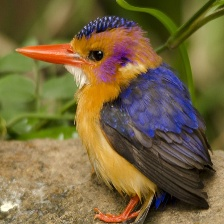

In [1]:
import os
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch
import GPUtil


print("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
GPUtil.showUtilization()

#file_path = '/workspace/data/test_data/cher_1.jpg'
file_path = '/workspace/data/bird_dataset/test/PYGMY KINGFISHER/3.jpg'
image = Image.open(file_path)
image

## GPU process

In [2]:
import torch
from transformers import ViTForImageClassification, AutoImageProcessor
import time

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#モデルのロード
best_checkpoint = 16500
model_id = f"/workspace/src/vit-weight/checkpoint-{best_checkpoint}"
model_gpu = ViTForImageClassification.from_pretrained(model_id).to(device)
image_processor_gpu =  AutoImageProcessor.from_pretrained(model_id)
len = 100 
start = time.time()

for _ in range(len):
    # 画像をテンソルに変換、GPUに移動
    inputs_gpu = image_processor_gpu(images=image, return_tensors='pt').to(device)
    
    # 推論
    with torch.no_grad():
        outputs_gpu = model_gpu(**inputs_gpu)
        logits_gpu = outputs_gpu.logits 
        predicted_idx_gpu = logits_gpu.argmax(-1).item() 

print('class:', model_gpu.config.id2label[predicted_idx_gpu]) 
fps = len/(time.time() - start)
print("FPS:", fps)
GPUtil.showUtilization()

cuda
class: PYGMY KINGFISHER
FPS: 21.76284647777463
| ID | GPU | MEM |
------------------
|  0 | 92% | 32% |


In [9]:
def get_prediction_probs(model, url_or_path, num_classes=3):
    img = Image.open(url_or_path)
    pixel_values = image_processor_gpu(img, return_tensors="pt")["pixel_values"].to(device)
    output = model_gpu(pixel_values)
    probs, indices = torch.topk(output.logits.softmax(dim=1), k=num_classes)
    id2label = model_gpu.config.id2label
    classes = [id2label[idx.item()] for idx in indices[0]]
    probs = probs.squeeze().tolist()
    results = dict(zip(classes, probs))
    return results

In [10]:
get_prediction_probs(model_id, file_path)

{'PYGMY KINGFISHER': 0.9989274144172668,
 'MALACHITE KINGFISHER': 0.0003117609303444624,
 'RUFOUS KINGFISHER': 0.00014921906404197216}

## CPU process

In [4]:
import torch
from transformers import ViTForImageClassification, AutoImageProcessor
import time

#CPUで実行
device = "cpu"
print(device)


# モデルと特徴抽出器をロード（SSLエラーの場合　プロキシと証明書を用意）
# image_processorは事前学習モデルを用いる
model_id = 'google/vit-base-patch16-224'
image_processor =  AutoImageProcessor.from_pretrained(model_id)
best_checkpoint = 16500
model = ViTForImageClassification.from_pretrained(f"/workspace/src/vit-weight/checkpoint-{best_checkpoint}").to(device)

len=100
start = time.time()

for _ in range(len):
    # 画像をテンソルに変換
    inputs = image_processor(images=image, return_tensors='pt').to(device)
    
    # 推論
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits 
        predicted_idx = logits.argmax(-1).item()
print('class:', model.config.id2label[predicted_idx]) 
fps = len/(time.time() - start)
print("FPS:", fps)

cpu
class: PYGMY KINGFISHER
FPS: 1.5991782664838718
